# Mauritius coast and potential impact of oil spill <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background

MV Wakashio ran aground off the south east coast of Mauritius on 25 July 2020 and spilled nearly 1,000 tonnes of fuel oil into the water in the following days.
This is expected to have a long term impact on the marine life and environment.

More [story](https://www.bbc.com/news/world-africa-53750151) and [photos of the oil spill](https://www.theatlantic.com/photo/2020/08/photos-growing-oil-spill-off-coast-mauritius/615136/).

## Description

This notebook investigtes how Sentinel-2 multi-spectral images can be used to measure and monitor the impact of the oil spill.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import numpy as np
import datacube
from odc.algo import xr_geomedian
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import rgb
from deafrica_dask import create_local_dask_cluster

### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
create_local_dask_cluster()

<Client: 'tcp://127.0.0.1:33523' processes=1 threads=2, memory=14.18 GB>

### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='mauritius')

## Load Sentinel-2 data from the datacube


In [4]:
# Create a query object
lat, lon = -20.4, 57.735
buffer = 0.04

query = {
    'time': ('2020-04', '2020-07'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'resolution':(-10, 10),
    'cloud_cover':(0, 60),
    'group_by': 'solar_day'
}

# use all non-overlapping 10m and 20m bands
bands = ['blue', 'green', 'red', 'nir', 'nir_narrow', 'red_edge_1', 'red_edge_2',
         'red_edge_3', 'swir_1', 'swir_2']

#bands = ['blue', 'green', 'red', 'nir', 'swir_1']

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)


ds = load_ard(dc=dc,
              products=['s2_l2a'],
              dask_chunks={'x': 500, 'y':500},
              output_crs=output_crs,
              measurements=bands,
              **query)

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 16 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 16, x: 840, y: 890)
Coordinates:
    spatial_ref  int32 32740
  * x            (x) float64 5.725e+05 5.725e+05 ... 5.809e+05 5.809e+05
  * y            (y) float64 7.749e+06 7.749e+06 7.749e+06 ... 7.74e+06 7.74e+06
  * time         (time) datetime64[ns] 2020-04-03T06:25:00 ... 2020-07-27T06:25:06
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nir_narrow   (time, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    red_edge_1   (time, y, x) float32 das

## Plot timesteps in true colour

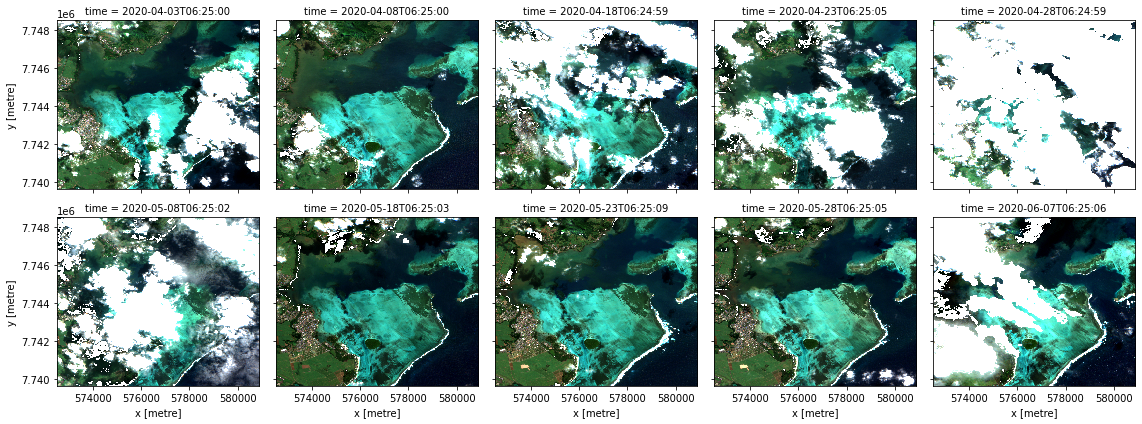

In [5]:
ds[['red','green','blue']].to_array().isel(time=slice(0,10)).plot.imshow(col='time', col_wrap=5, robust=True);

## Generate a geomedian

In [6]:
#generate a geomedian
geomedian = xr_geomedian(ds)

Automatically using 16 threads.


In [7]:
%%time
geomedian = geomedian.compute()

CPU times: user 3.4 s, sys: 247 ms, total: 3.64 s
Wall time: 2min 24s


In [8]:
print(geomedian)

<xarray.Dataset>
Dimensions:     (x: 840, y: 890)
Coordinates:
  * y           (y) float64 7.749e+06 7.749e+06 7.749e+06 ... 7.74e+06 7.74e+06
  * x           (x) float64 5.725e+05 5.725e+05 ... 5.809e+05 5.809e+05
Data variables:
    blue        (y, x) float32 847.7998 771.5749 ... 287.36145 287.94495
    green       (y, x) float32 1015.1274 914.3728 ... 150.8254 164.27695
    red         (y, x) float32 831.9276 762.891 708.12317 ... 87.13605 101.82751
    nir         (y, x) float32 2900.1248 3120.3037 ... 86.171844 96.705086
    nir_narrow  (y, x) float32 3134.1187 3407.3052 ... 93.71784 103.180504
    red_edge_1  (y, x) float32 1132.6711 1093.1809 ... 94.71567 101.352486
    red_edge_2  (y, x) float32 2380.4583 2537.2075 ... 87.50486 100.774864
    red_edge_3  (y, x) float32 2983.2527 3214.9478 ... 96.86656 106.69859
    swir_1      (y, x) float32 1164.0457 1188.6086 ... 101.88413 116.68357
    swir_2      (y, x) float32 767.73254 780.3656 ... 101.34339 116.76765


## Plot the geomedian in true and false color

Plotting the result, we can see that the geomedian image is much more complete than any of the individual images. 

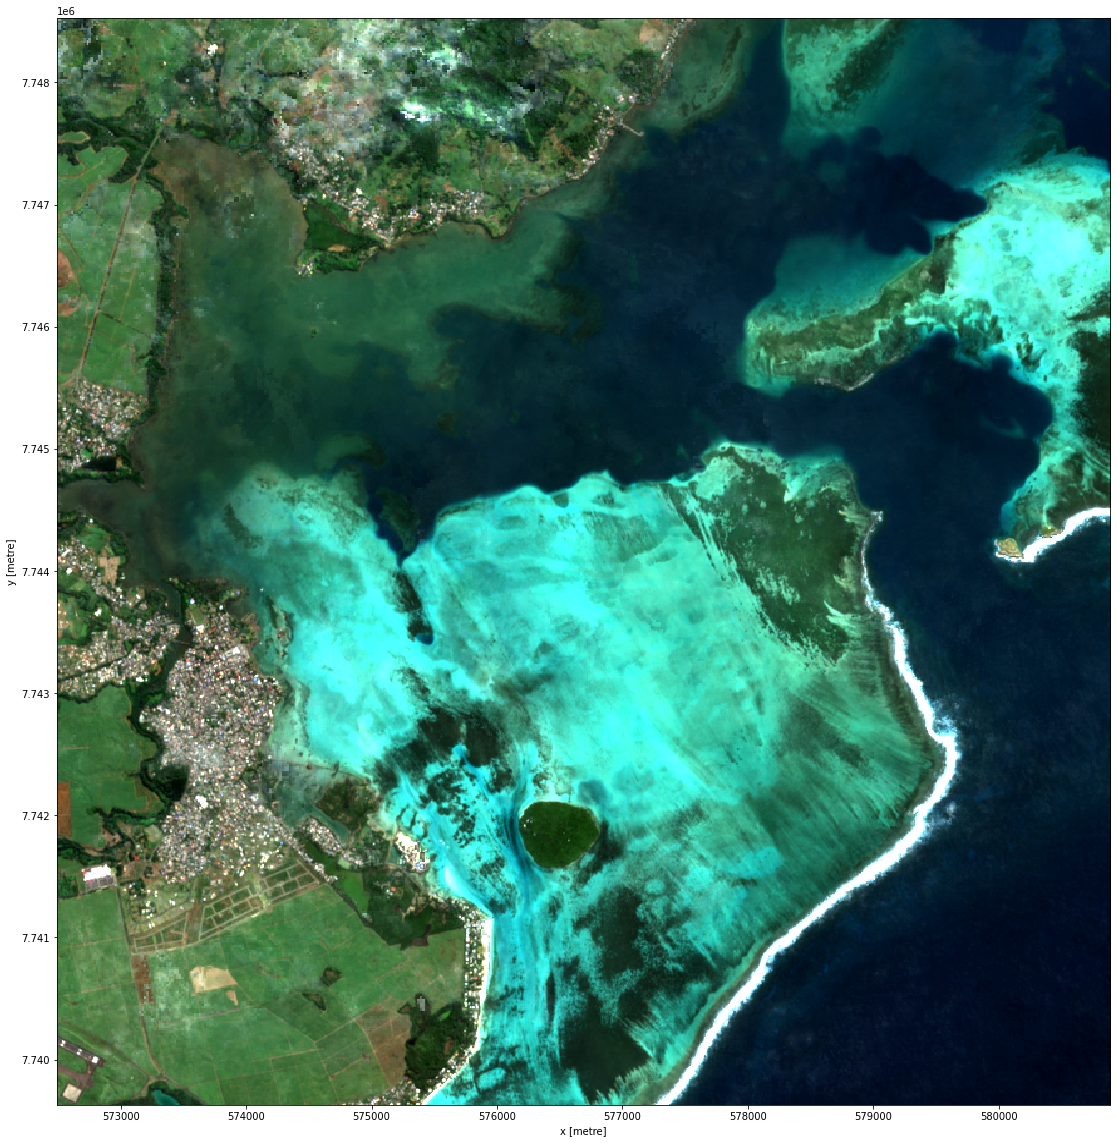

In [9]:
# Plot true color
rgb(geomedian, size=20)

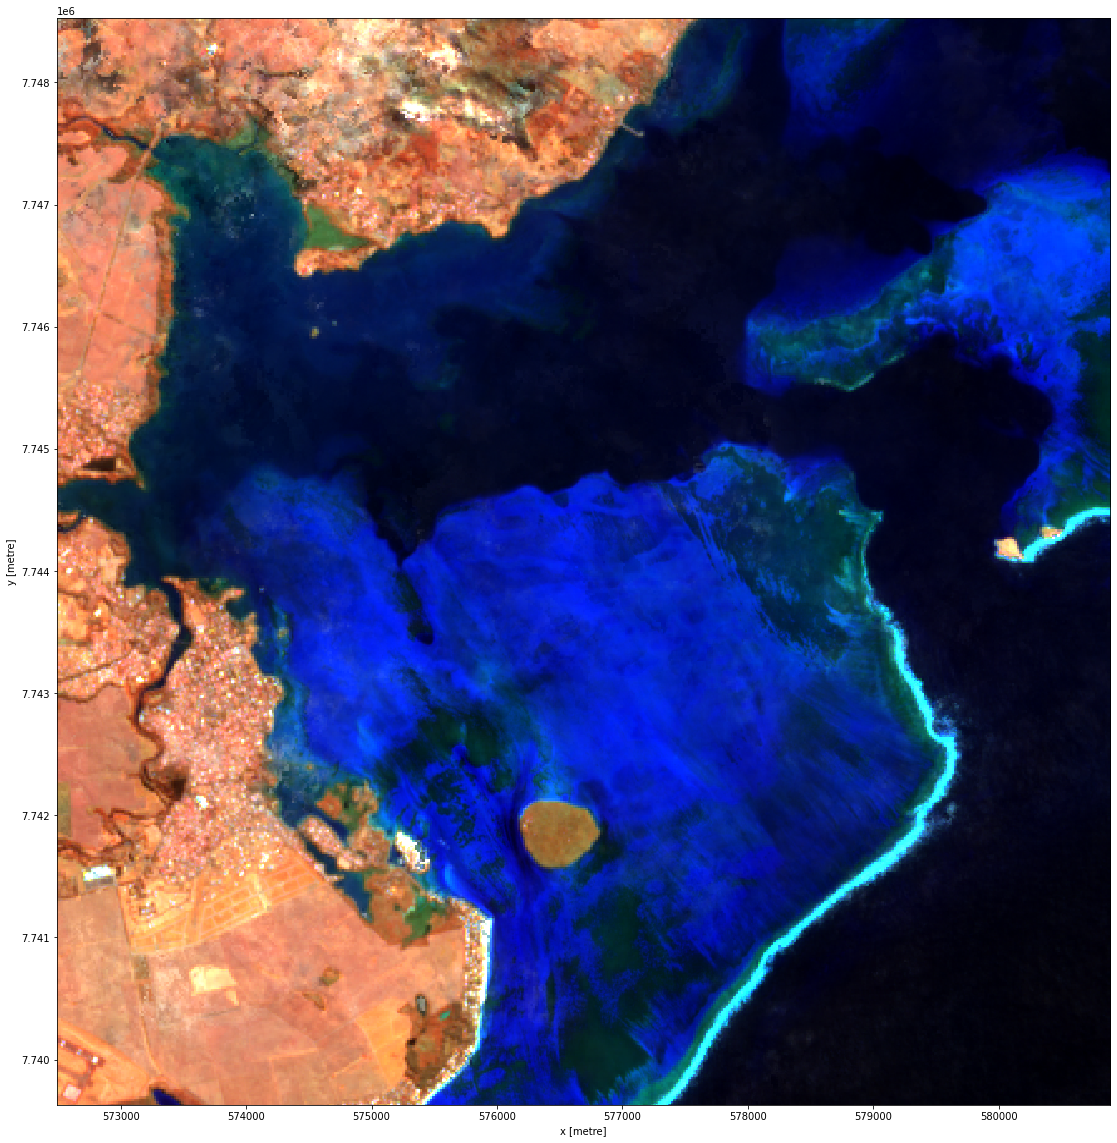

In [10]:
# Plot false color
rgb(geomedian, bands=['swir_1', 'red_edge_1', 'green'], size=20)

## Run a Principle Component Analysis

This helps to visualize geomedian in RGB, showing the different types of surface characterics that can be distinguished by the Sentinel-2 spectral bands.

In [11]:
from deafrica_classificationtools import sklearn_flatten, sklearn_unflatten
from sklearn.decomposition import PCA

X = sklearn_flatten(geomedian)
pca = PCA(n_components=3)
pca.fit(X)
print("Relative variance in principal components:", pca.explained_variance_ratio_)
predict = pca.transform(X)
out = sklearn_unflatten(predict, geomedian)
out = out.to_dataset(dim=out.dims[0]).transpose('y','x')


Relative variance in principal components: [0.91615082 0.06186968 0.01396172]


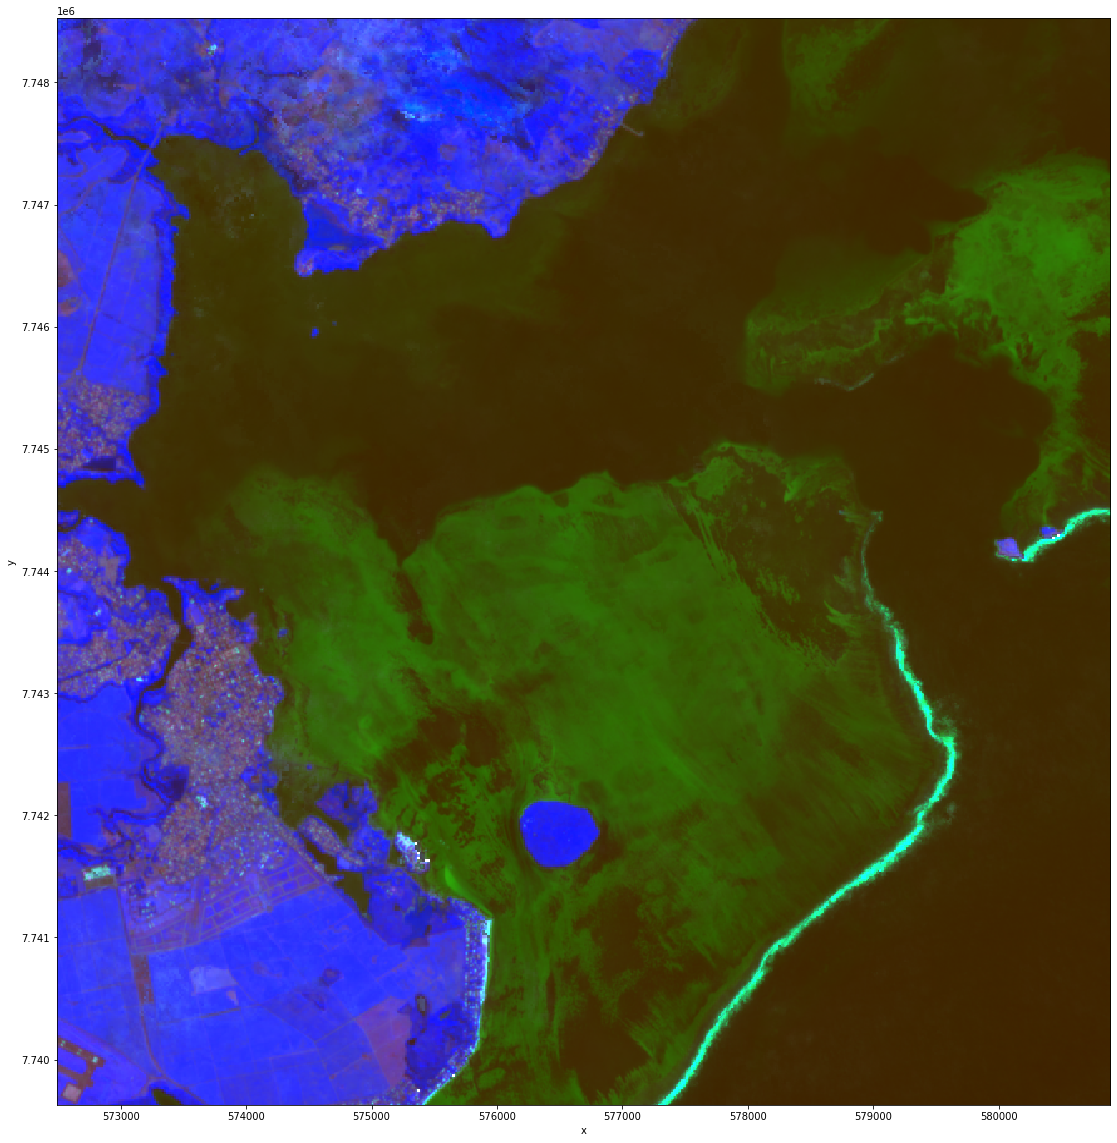

In [12]:
rgb(out, bands=[2,1,0], size=20)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** August 2020

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()